# Shell Structure Indicators in Atoms
This notebook explores various shell-structure indicators for atomic ions using [`AtomDB`](https://atomdb.qcdevs.org/api/index.html).

One of the simplest, and most widely used, descriptors is the Laplacian of the electron density, $\rho(r)$: 
$$
\nabla^2 \rho(\mathbf{r}) = \tfrac{d^2 \rho(r)}{dr^2} + \tfrac{2}{r} \tfrac{d \rho(r)}{dr}
$$
One can also use the electron localization function (ELF)
$$
\xi(r) = \frac{t(r)-t_w(r)}{t_{TF}(r)}
$$
or the localized orbital locator (LOL) or nighness indicator,
$$
L(r) = \frac{t(r)}{t_{TF}(r)}
$$
where $t(r)$ is the (positive-definite) kinetic energy density, 
$$
t_{TF}(r) = \frac{3}{10} (3 \pi^2)^{2/3} \rho(r)^{5/3}
$$
is the Thomas-Fermi kinetic energy density, and 
$$
t_w(r) = \frac{1}{8 \rho(r)} \left( \frac{d \rho(r)}{dr} \right)^2
$$
is the Weizsäcker kinetic energy density.

To map these onto a sensible interval, we choose a hyperbolic tangent mapping, though this is a bit unconventional. For an (arbitrary) shell-structure indicator $\eta(r)$, one uses,

$$
\tanh(\eta(r)^{-1}-\eta(r))
$$

# If using Google Co-Lab, uncomment the line below and run it to install AtomDB. 
# If AtomDB is already installed in your local environment you do not need to do this.
#!pip install qc-atomdb

In [35]:
# Install key tools
import numpy as np
from atomdb import load
import matplotlib.pyplot as plt


In [36]:
# Compute the Weizsacker kinetic energy

relevant functions from AtomDB library: 

dens_func:    Return a cubic spline of the electronic density.\
d_dens_func:  Return a cubic spline of the first derivative of the electronic density.\
dd_dens_func: Return a cubic spline of the electronic density Laplacian.\
ked_func:     Return a cubic spline of the kinetic energy density.


$\xi_{\sigma}(r) = \frac{\rho_{\sigma}(r) \kappa_{\sigma}^{BE}(r) [\rho_{\alpha}, \rho_{\alpha}]}{(2/3)\{(3/10)(6\pi^2)^{2/3} \rho_{\sigma}^{5/3}(r)\}}$\
$\rho(r) = $ dens\
$\kappa_{\sigma}^{BE}(r) [\rho_{\alpha}, \rho_{\alpha}]=  \frac{2}{3} \frac{\tau_{\sigma}(r) - \tau_{\sigma}^{W}(r)}{\rho_{\sigma}}$\
$\tau_{\sigma}=$ ked_func\
$\tau_{\sigma}^{W}(r)=\sum_{i=1}^{N_{\sigma}} \frac{\nabla \rho(r) \nabla \rho(r)}{8 \rho_{\sigma}(r)}$:

In [37]:
# Evaluate the density and its derivatives on a grid
def evaluate_splines(atom_obj,grid):
    ''' Compute the density, its derivatives, and the kinetic energy density on a grid
    Parameters
    ----------
    atom_obj : AtomDB object
        AtomDB object for the species of interest.
    grid : np.ndarray
        Grid of points where the density and its derivatives are evaluated

    Returns
    -------
    rho : np.ndarray
        Density
    grad_rho : np.ndarray
        Radial gradient of the density
    lapl_rho : np.ndarray
        Radial Laplacian of the density
    tau : np.ndarray
        Positive-definite kinetic energy density
    '''
    # Get the cubic splines for the density and its derivatives,
    # 't' indicates the total density (sum of spin-up and spin-down)
    dens_spline = atom_obj.dens_func(spin="t")
    d_dens_spline = atom_obj.d_dens_func(spin="t")
    dd_dens_spline = atom_obj.dd_dens_func(spin="t")
    tau_spline = atom_obj.ked_func(spin="t")

    # Evaluate the density and its derivatives on the grid
    rho = dens_spline(grid)
    grad_rho = d_dens_spline(grid)
    lapl_rho = dd_dens_spline(grid)
    tau = tau_spline(grid)

    return rho, grad_rho, lapl_rho, tau

# Evaluate the Weizsacker kinetic energy density
def tau_w(rho,grad_rho):
    ''' Compute the Weizsacker kinetic energy density
    Parameters
    ----------
    rho : np.ndarray
        Density evaluated on a grid
    grad_rho : np.ndarray
        Radial gradient of the density evaluated on the same grid

    Returns
    -------
    tau_W : np.ndarray
        Weizsacker kinetic energy density
    '''

    # Check to make sure that the density and gradient of the density have the same shape/size.
    if rho.shape != grad_rho.shape:
        raise ValueError("The density and its gradient must have the same shape.")

    return grad_rho**2 / (8 * rho)


# Evaluate the Thomas-Fermi kinetic energy density
def tau_tf(rho):
    ''' Compute the Thomas-Fermi kinetic energy density
    Parameters
    ----------
    rho : np.ndarray
        Density evaluated on a grid

    Returns
    -------
    tau_TF : np.ndarray
        Thomas-Fermi kinetic energy density
    '''
    #I feel like the first formula is right, but the second formula seems to give
    #a better result.
    return (3.0 / 10.0) * (3.0 * np.pi ** 2) ** (2.0 / 3.0) * rho ** (5.0 / 3.0)
    #return (3.0 / 10.0) * (6.0 * np.pi ** 2) ** (2.0 / 3.0) * rho ** (5.0 / 3.0)

# Electron localization indicator
def xi_elf(tau,tau_w,tau_tf):
    ''' Compute the electron localization indicator
    Parameters
    ----------
    tau : np.ndarray
        Positive-definite kinetic energy density
    tau_w : np.ndarray
        Weizsacker kinetic energy density
    tau_tf : np.ndarray
        Thomas-Fermi kinetic energy density

    Returns
    -------
    xi_elf : np.ndarray
        Electron localization indicator. This is the quantity,
        which goes for 0 to +infinity, that we map to a finite
        interval to indicate shells.
    '''
    # Ensure the input arrays all have the same size
    if tau.shape != tau_w.shape or tau.shape != tau_tf.shape:
        raise ValueError("The kinetic energy densities must have the same shape.")

    # We want to ensure that we don't overflow as the Thomas-Fermi k.e. density in
    # the denominator gets too small
    # Initialize the array to zero
    xi_elf = np.zeros_like(tau)
    xi_elf = np.where(tau_tf < np.finfo(float).tiny, xi_elf, (tau - tau_w) / tau_tf)

    return xi_elf

# Localized Orbital Locator
def xi_lol(tau,tau_tf):
    ''' Compute the localized orbital locator
    Parameters
    ----------
    tau : np.ndarray
        Positive-definite kinetic energy density
    tau_tf : np.ndarray
        Thomas-Fermi kinetic energy density

    Returns
    -------
    xi_lol : np.ndarray
        Localized orbital locator. This is the quantity,
        which goes for 0 to +infinity, that we map to a finite
        interval to indicate shells.
    '''
    # Ensure the input arrays all have the same size
    if tau.shape != tau_tf.shape:
        raise ValueError("The kinetic energy densities must have the same shape.")

    # We want to ensure that we don't overflow as the Thomas-Fermi k.e. density in
    # the denominator gets too small
    # Initialize the array to zero
    xi_lol = np.zeros_like(tau)
    xi_lol = np.where(tau_tf < np.finfo(float).eps, xi_lol, tau / tau_tf)

    return xi_lol

# Mapping to [0,1] using the hyperbolic tangent
def loc_index(xi, inverse=True):
    ''' Map the localization index to the interval [0,1] using the hyperbolic tangent

    Parameters
    ----------
    xi : np.ndarray
        Localization index
    inverse : bool, optional
        If True, large values of xi correspond to high localization.   `
        If False, large values of xi correspond to low localization.

    Returns
    -------
    loc_index : np.ndarray
        Localization index mapped to the interval [0,1]
    '''
    loc_index = np.tanh(xi - xi**(-1))

    if inverse:
        loc_index *= -1

    return loc_index

In [38]:
# Load Data From Server, Neon Atom in Slater Basis
atom_obj = load(elem="Zn", charge=0, mult=1, dataset="gaussian")

# Choose points to evaluate points. Avoid the origin to prevent division by zero.
rad_grid = np.linspace(0.001, 6.0, 1000)

# Compute the key quantities of interest,
rho, grad_rho, lapl_rho, tau = evaluate_splines(atom_obj,rad_grid)
tau_w_array = tau_w(rho,grad_rho)
tau_tf_array = tau_tf(rho)
xi_elf_array = xi_elf(tau,tau_w_array,tau_tf_array)
xi_lol_array = xi_lol(tau,tau_tf_array)
loc_index_elf = loc_index(xi_elf_array, inverse=True)
loc_index_lol = loc_index(xi_lol_array)

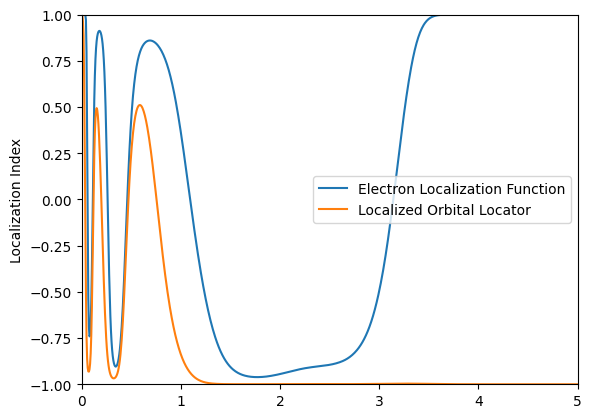

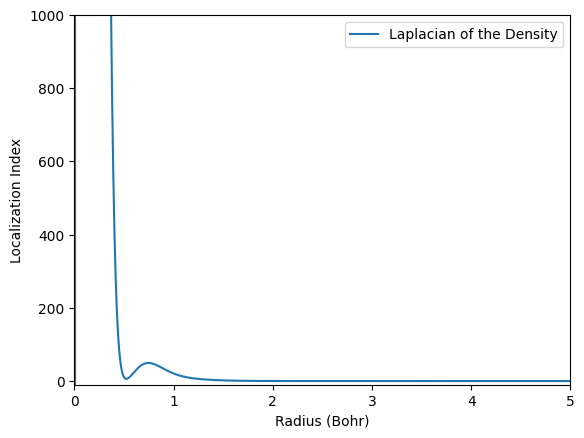

In [42]:
# Plot the localized orbital locator, electron localization function, and Laplacian.
plt.figure()
plt.plot(rad_grid, loc_index_elf, label="Electron Localization Function")
plt.plot(rad_grid, loc_index_lol, label="Localized Orbital Locator")
#plt.plot(rad_grid, lapl_rho, label="Laplacian of the Density")
# Set x and y limits
plt.ylim(-1, 1)
plt.xlim(0, 5)
plt.ylabel("Radius (Bohr)")
plt.ylabel("Localization Index")
plt.legend()
plt.show()

# Plot the Laplacian.
plt.figure()
#plt.plot(rad_grid, loc_index_elf, label="Electron Localization Function")
#plt.plot(rad_grid, loc_index_lol, label="Localized Orbital Locator")
plt.ylim(-10, 1000)
plt.xlim(0, 5)
plt.plot(rad_grid, lapl_rho, label="Laplacian of the Density")
plt.xlabel("Radius (Bohr)")
plt.ylabel("Localization Index")
plt.legend()
plt.show()

In [40]:
#

NameError: name 'L' is not defined

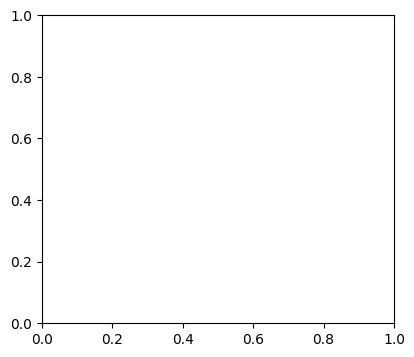

In [41]:
# plot Density and Kinetic Energy Density

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
#ax2 = fig.add_subplot(122)

ax1.plot(rad_grid, L, "-b", linewidth=2)
ax1.set(xlabel="Radial distance [Bohr]", ylabel=r"$\mathcal{L}$ ")

#ax1.set_yscale("symlog")
#ax1.set_ylim(top=10, bottom=0.00001)
ax1.set_xlim(left=0.0, right=3.5)


ax2 = fig.add_subplot(122)

ax2.plot(rad_grid, ked, "-g", linewidth=2, label = r"$\tau$")
ax2.plot(rad_grid, Weizaecker, "-r", linewidth=2, label = r"$\tau^{W}$")
ax2.set(xlabel="Radial distance [Bohr]", ylabel="KED")
ax2.legend()
ax2.set_yscale("symlog")
ax2.set_xlim(left=0.0, right=6)

plt.show()